# Name and ID: Hoang Tu Bui - 24005665

# The code executes till the end without any errors

# Original source: 

1. https://medium.com/@liyinxuan0213/step-by-step-double-deep-q-networks-double-dqn-tutorial-from-atari-games-to-bioengineering-dec7e6373896
1. https://stackoverflow.com/questions/26587527/cite-a-paper-using-github-markdown-syntax

# Why Reinforcement Learning is the ML paradigm of choice for this task?

Reinforcement Learning (RL) is well-suited for Atari games like Breakout where an agent must learn to make decisions through trial and error, optimizing its actions based on feedback in the form of rewards. This paradigm is distinct from supervised learning, which relies on pre-labeled data, and unsupervised learning, which seeks to find patterns without any labeled responses ([Shaheen et al., 2025](#deepmind-ateri-2025)).

In Breakout, the agent must learn to control a paddle to bounce a ball and break bricks, receiving rewards only when bricks are broken. This setup presents a challenge where the agent must learn the consequences of its actions over time, making RL an ideal approach . ​

The success of RL in Breakout not only showcases its effectiveness in gaming but also highlights its potential in real-world applications where decision-making under uncertainty and learning from interaction are crucial.​

In summary, RL's framework aligns seamlessly with the challenges presented by Breakout, making it the machine learning paradigm of choice for such tasks.​

# The Environment

1. The game selected: **Breakout**

    The goal is to control a paddle in order to hit a ball toward brick walls at the top of the screen and to break them ([AtariAge - Atari 2600 Manuals (HTML) - Breakout (Atari), 1997-1998](#breakout-description)). The player starts with 5 lives and loses a life if the ball drops. The game terminates and resets when all lives are lost.

1. The input from the environment: A 210x160 RGB image frame from the game screen, where each pixel value is an unsigned 8-bit integer ranging from 0 to 255 ([Implementation/Game environment](#game-environment)).

1. The control settings: four Discrete actions ([Machado et al., 2018](#ale-breakout-doc)):
    - 0:NOOP (No Operation)
    - 1:FIRE
    - 2:RIGHT
    - 3:LEFT

# Implementation

## Game environment

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


Action space: Discrete(4)
Observation space: Box(0, 255, (210, 160, 3), uint8)


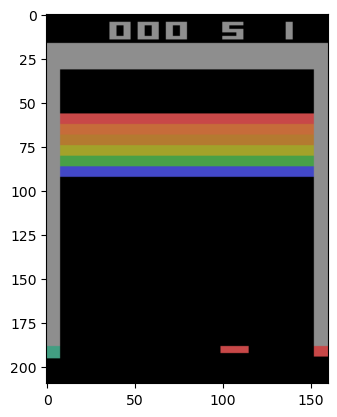

In [1]:
import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt


gym.register_envs(ale_py)
org_env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

print(f"Action space: {org_env.action_space}")
print(f"Observation space: {org_env.observation_space}")

org_env.reset()
rgb_arr = org_env.render()

assert rgb_arr is not None, "Rendering empty array"
plt.imshow(rgb_arr)
plt.show()

<a id="obs-preprocess"></a> 
I noticed that the observation includes redundant information — specifically, the scoreboard at the top, which takes up 20 pixels. Thus they will be cut of using Gymnasium Wrappers. Finally, a Normalize wrapper scales pixel value from [0,255] to [0,1].

Other modifications (preprocess) to the onservations include:

1. ResizeObservation((84, 84)): resizes the input frame to 84x84 in order to ensure the input to be in fixed size and reduce computation
1. GrayscaleObservation: reduces input dimensionality from 3 channels (rgb) to 1 (gray) while preserving essential information
1. FrameStackObservation(4): Stacks the last 4 grayscale frames together to provide temporal context
1. EpisodicLifeEnv: Mark the loss of life as end of episode but does not reset the environment. [Shaheen et al., 2025](#deepmind-ateri-2025) found out that it helps value estimation
1. MaxAndSkipObservation(skip=4): reduces computation and removes flickering artifacts 
1. FireResetEnv: For certain games like Breakout, after life loss, the game is fixed until firing
1. RecordEpisodeStatistics: keeps track of cumulative rewards and episode lengths.

In [2]:
from gymnasium.spaces import Box
from stable_baselines3.common.atari_wrappers import (
    EpisodicLifeEnv,
    MaxAndSkipEnv,
    FireResetEnv,
)


# Cut 20 pixels from the top
org_obs_space = org_env.observation_space
assert isinstance(org_obs_space, Box), "Observation space is not a Box"
env = gym.wrappers.TransformObservation(
    org_env,
    lambda obs: obs[20:, :, :],
    observation_space=Box(
        low=org_obs_space.low[20:, :, :],
        high=org_obs_space.high[20:, :, :],
        dtype=org_obs_space.dtype,  # type: ignore
    ),
)

# Resize from 210x160 to 84x84
env = gym.wrappers.ResizeObservation(env, (84, 84))
# Convert rgb to grayscale
env = gym.wrappers.GrayscaleObservation(env)
# Stack 4 frames for temporal information
env = gym.wrappers.FrameStackObservation(env, 4)
# mark end of life == end-of-episode
env = EpisodicLifeEnv(env)
# Only change action every 4th frame
env = MaxAndSkipEnv(env, skip=4)
# Reset with FIRE action
env = FireResetEnv(env)
# Scale pixels to [0, 1]
env = gym.wrappers.TransformObservation(
    env,
    lambda obs: obs / 255.0,
    observation_space=Box(
        low=0.0,
        high=1.0,
        shape=env.observation_space.shape,
        dtype=env.observation_space.dtype,  # type: ignore
    ),
)
# record episode reward and length
env = gym.wrappers.RecordEpisodeStatistics(env)

### Observation from the environment

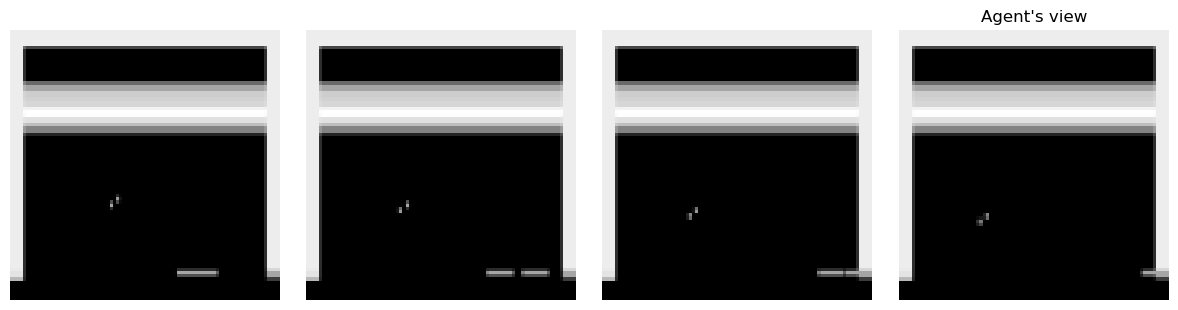

In [3]:
obs, _ = env.reset()

# plot 4 channels of the observation
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(obs.squeeze()[i], cmap="gray")
    axes[i].axis("off")
plt.tight_layout()
plt.title("Agent's view")
plt.show()


## VANILLA DQN

### Capture and pre-processing of the data

Explained in section [Game environment](#obs-preprocess)

### Network structure

The Deep Q-Network (DQN) implemented here is a convolutional neural network designed to process stacks of image frames, typical in Atari-based reinforcement learning environments. The architecture follows the structure used in the original DeepMind DQN paper by [Mnih et al. (2015)](#deepmind-ateri-2015).
The input to the network is a tensor of shape (4, 84, 84), representing four stacked grayscale frames.

The layers are as follows:

1. **Convolutional Layer 1**

   * `in_channels = 4`, `out_channels = 32`, `kernel_size = 8`, `stride = 4`
   * Output shape: `(32, 20, 20)`

2. **ReLU Activation**

3. **Convolutional Layer 2**

   * `in_channels = 32`, `out_channels = 64`, `kernel_size = 4`, `stride = 2`
   * Output shape: `(64, 9, 9)`

4. **ReLU Activation**

5. **Convolutional Layer 3**

   * `in_channels = 64`, `out_channels = 64`, `kernel_size = 3`, `stride = 1`
   * Output shape: `(64, 7, 7)`

6. **ReLU Activation**

7. **Flatten Layer**

   * Flattens the output from shape `(64, 7, 7)` to a vector of length `3136` (i.e., `64*7*7`)

8. **Fully Connected Layer 1**

   * `in_features = 3136`, `out_features = 512`

9. **ReLU Activation**

10. **Fully Connected Output Layer**

    * `in_features = 512`, `out_features = n_actions`
    * Outputs one Q-value per discrete action.


**In short**, the network extracts spatial features from the input frames using convolutional layers, then maps them through fully connected layers to a Q-value for each possible action.

In [4]:
from torch import nn


class DQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
        )

    def forward(self, x):
        return self.network(x.float())
    
print(DQN(4))

DQN(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)


### Q learning update applied to the weights

In this implementation, Deep Q-Learning is used to train a neural network to approximate the optimal action-value function $Q^*(s, a)$. The network parameters are updated using samples from a Replay Buffer, with the target computed from a fixed target network.

At every train_freq steps (e.g. every 4 steps), if enough transitions are stored, the following update is applied:

1. The weights are updated to minimize the **Huber loss** between the predicted Q-value and the target:

    $$
    \text{Loss} = \text{Huber}(Q(s_t, a_t) - y_t)
    $$

    where the **target** $y_t$ is defined as:

    $$
    y_t = r_t + \gamma \cdot \max_{a'} Q_{\text{target}}(s_{t+1}, a') \cdot (1 - \text{done})
    $$

    Here:

    * $Q(s_t, a_t)$: is the estimated Q-value from the online network for the selected action
    * $Q_{\text{target}}(s_{t+1}, a')$: is the max predicted Q-value from the target network
    * $r_t$: is the clipped reward at time $t$
    * $\gamma$: is the discount factor
    * $\text{done}$: is a binary flag indicating episode termination

1. Mechanics

    1. Sample a minibatch of transitions $(s, a, r, s', \text{done})$ from the replay buffer
    2. Compute current Q-values for $s$ using the online network
    3. Compute target Q-values for $s'$ using the target network (no gradients)
    4. Compute loss between current and target Q-values using `F.huber_loss`
    5. Backpropagate the loss and update the online network weights via Adam optimizer
    6. Every $C$ steps, **synchronize the target network** with the online network


In [5]:
import copy
from gymnasium import Env
from stable_baselines3.common.buffers import ReplayBuffer
import torch
from torch.optim.adam import Adam
import torch.nn.functional as F
import random
import numpy as np


def DQN_train(
    env: Env,
    model: nn.Module,
    device="cuda",
    buffer_size=10_000,
    n_episodes=30_000,
    train_feq=4,
    batch_size=96,
    gamma=0.99,
    replay_start_size=50,
    epsilon_start=1,
    epsilon_end=0.1,
    exploration_steps=1_000,
    C=10,  # Target network update frequency
    learning_rate=1.25e-4,
    verbose=False,
):

    # Initialize replay memory D to capacity N
    rb = ReplayBuffer(
        buffer_size,
        env.observation_space,
        env.action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )

    model.train()
    # target action-value function Q_hat
    targetNetwork = copy.deepcopy(model).to(device)
    # action-value function Q
    onlineNetwork = model.to(device)

    optimizer = Adam(onlineNetwork.parameters(), lr=learning_rate)

    # train loop variables
    episodeRewards = []
    bestEpisodeReward = -float("inf")
    framePerEpisodes = []
    losses = []
    step = 0
    for episode in range(n_episodes):
        episodeReward = 0

        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        obs, _ = env.reset()

        for _ in range(random.randint(1, 30)):  # random actions to reset environment
            obs, *_, info = env.step(env.action_space.sample())

        done = False
        while not done:
            current_life = info["lives"]

            epsilon = max(
                (
                    (epsilon_end - epsilon_start) / exploration_steps * step
                    + epsilon_start
                ),
                epsilon_end,
            )

            # With probability ε select a random action a
            if random.random() < epsilon:
                action = np.array(env.action_space.sample())
            # Otherwise select a = max_a Q∗(φ(st), a; θ)
            else:
                q_values = onlineNetwork(torch.Tensor(obs).unsqueeze(0).to(device))
                action = np.array(torch.argmax(q_values, dim=1).item())

            # Execute action a in emulator and observe reward rt and image xt+1
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            reward = float(reward)

            # action leads to a life lost
            lostLife = np.array(info["lives"] < current_life)
            if lostLife:
                reward = -1

            # Set st+1 = st, at, xt+1 and preprocess φt+1 = φ(st+1)
            real_next_obs = next_obs.copy()

            episodeReward += reward
            reward = np.clip(reward, -1, 1)  # Reward clipping

            # Store transition (φt, at, rt, φt+1) in D
            rb.add(obs, real_next_obs, action, reward, lostLife, [info])

            obs = next_obs

            if step > replay_start_size and step % train_feq == 0:
                # Sample random minibatch of transitions (φj , aj , rj , φj +1 ) from D
                data = rb.sample(batch_size)

                currQ_Vals = onlineNetwork(data.observations).gather(1, data.actions)
                currQ_Val = currQ_Vals.squeeze()

                with torch.no_grad():
                    maxQ_Val, _ = targetNetwork(data.next_observations).max(dim=1)

                # if done then there is no next Q_value -> use mask of dones
                y = data.rewards.flatten() + (
                    gamma * maxQ_Val * (1 - data.dones.flatten())
                )

                loss = F.huber_loss(y, currQ_Val)

                # Perform a gradient descent step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

            step += 1

            # Every C steps reset Q_hat=Q
            if step % C == 0:
                targetNetwork.load_state_dict(onlineNetwork.state_dict())

        try:
            episodeInfo = info["episode"]
        except KeyError:
            episodeInfo = {}

        episodeRewards.append(episodeReward)
        if episodeReward > bestEpisodeReward:
            bestEpisodeReward = episodeReward

        if episodeInfo.get("l"):
            framePerEpisode = episodeInfo["l"]
            framePerEpisodes.append(framePerEpisode)

            if verbose:
                print(
                    f"Episode: {episode}, "
                    f"Episode reward: {episodeReward:.2f}, "
                    f"Best episode reward: {bestEpisodeReward:.2f}, "
                    f"Episode length: {framePerEpisode}, "
                    f"Epsilon: {epsilon:.4f}, "
                )

    return (
        targetNetwork,
        episodeRewards,
        framePerEpisodes,
        losses,
    )

In [ ]:
assert isinstance(env.action_space, gym.spaces.Discrete), "Action space is not discrete"
model = DQN(env.action_space.n)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

trainConfigs = {
    "buffer_size": 500_000,
    "n_episodes": 100_000,
    "batch_size": 96,
    "gamma": 0.99,
    "replay_start_size": 50_000,
    "epsilon_start": 1,
    "epsilon_end": 0.1,
    "exploration_steps": 1_000_000,
    "C": 10_000,
    "learning_rate": 1.25e-4,
}

model, rewards, episodeLen, losses, *_ = DQN_train(
    env,
    model,
    device=device,
    verbose=True,
    **trainConfigs,
)

Using device: cuda


/home/tu/micromamba/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.12GB > 13.77GB
  warnings.warn(


Episode: 0, Episode reward: -1.00, Best episode reward: -1.00, Episode length: 2, Epsilon: 1.0000, 
Episode: 1, Episode reward: 0.00, Best episode reward: 0.00, Episode length: 16, Epsilon: 1.0000, 
Episode: 2, Episode reward: -1.00, Best episode reward: 0.00, Episode length: 24, Epsilon: 1.0000, 
Episode: 3, Episode reward: 0.00, Best episode reward: 0.00, Episode length: 18, Epsilon: 1.0000, 
Episode: 4, Episode reward: 0.00, Best episode reward: 0.00, Episode length: 12, Epsilon: 1.0000, 
Episode: 5, Episode reward: -1.00, Best episode reward: 0.00, Episode length: 18, Epsilon: 1.0000, 
Episode: 6, Episode reward: 0.00, Best episode reward: 0.00, Episode length: 24, Epsilon: 1.0000, 
Episode: 7, Episode reward: -1.00, Best episode reward: 0.00, Episode length: 29, Epsilon: 1.0000, 
Episode: 8, Episode reward: -1.00, Best episode reward: 0.00, Episode length: 29, Epsilon: 1.0000, 
Episode: 9, Episode reward: 0.00, Best episode reward: 0.00, Episode length: 9, Epsilon: 1.0000, 
Episod

### Evaluation

#### Plots

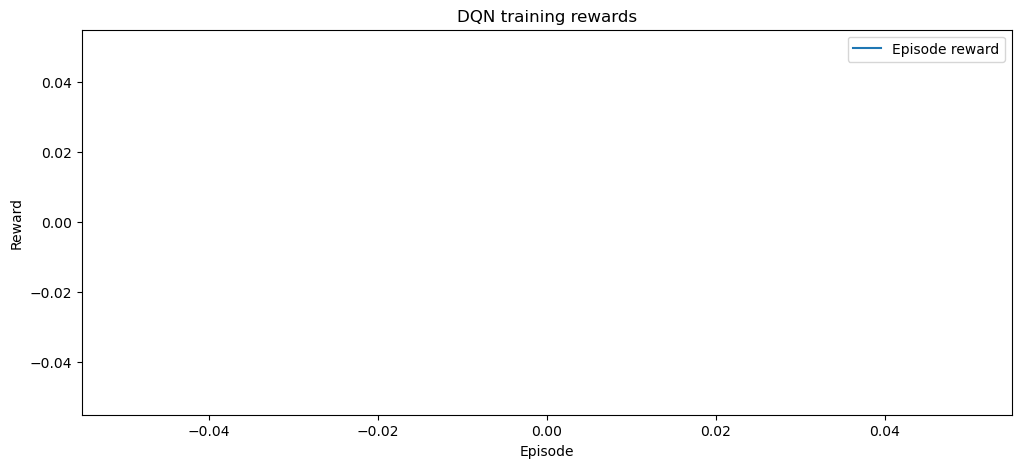

In [ ]:
# plot rewards over episodes
plt.figure(figsize=(12, 5))
plt.plot(rewards, label="Episode reward")
# add moving average (100)
plt.plot(
    np.convolve(rewards, np.ones(100) / 100, mode="valid"),
    label="Moving average reward",
)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN training rewards")
plt.legend()
plt.show()

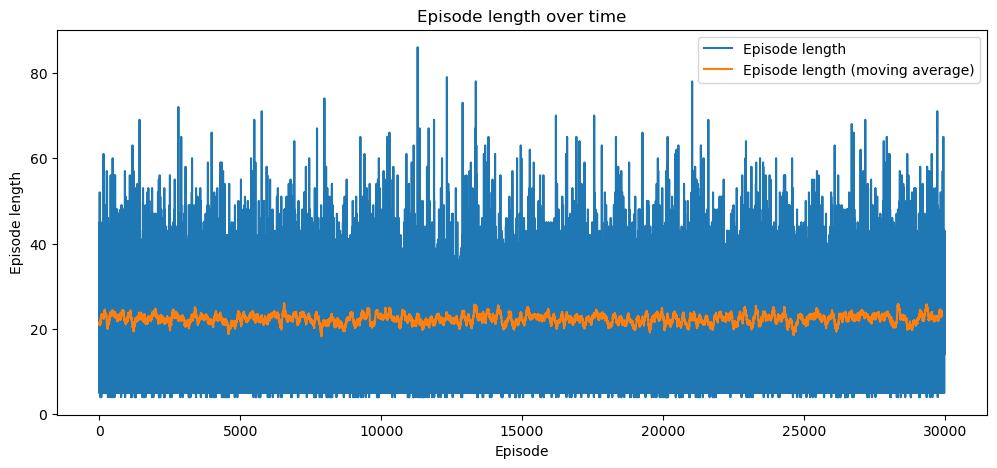

In [ ]:
# plot frame per episode
plt.figure(figsize=(12, 5))
plt.plot(episodeLen, label="Episode length")
# add moving average (100)
plt.plot(
    np.convolve(episodeLen, np.ones(100) / 100, mode="valid"),
    label="Episode length (moving average)",
)
plt.xlabel("Episode")
plt.ylabel("Episode length")
plt.title("Episode length over time")
plt.legend()
plt.show()

In [ ]:
# plot losses
plt.figure(figsize=(12, 5))
plt.plot(losses, label="Loss")
# add moving average (100)
plt.plot(
    np.convolve(losses, np.ones(100) / 100, mode="valid"),
    label="Loss (moving average)",
)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.legend()
plt.show()

#### How does one evaluate the performance of the RL agent

In [ ]:
def play(model: nn.Module, env: Env, device, n_episodes, render):
    model.to(device)
    model.eval()

    frames = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        dead = False
        
        # start with fire option
        action = 1

        while not dead:
            obs, _, terminated, truncated, _ = env.step(action)
            
            dead = terminated or truncated
            
            if len(frames) < render:
                frames.append(env.render())

            with torch.no_grad():
                obs_tensor = torch.tensor(obs).unsqueeze(0).to(device)

                q_values = model(obs_tensor)
                action = np.array(torch.argmax(q_values, dim=1).item())


            if terminated or truncated:
                action = 1
                
            
    return frames

In [ ]:
from matplotlib import animation
from IPython.display import HTML


frames = play(model, env, "cpu", n_episodes=20, render=1000)

# Keep 3_rd frames
frames = [frames[i] for i in range(0, len(frames), 3)]

print(f"Drawing {len(frames)} frames")
fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])


def update_frame(frame):
    im.set_data(frame)
    return [im]


ani = animation.FuncAnimation(fig, update_frame, frames=frames, interval=50)
plt.close(fig)
HTML(ani.to_jshtml())

Drawing 52 frames


#### Is the agent learning?

## DOUBLE DQN

### Problem

### Theoretical solution

In [ ]:
def doubleDQN_train(
    env: Env,
    model: nn.Module,
    device="cuda",
    buffer_size=10_000,
    n_episodes=30_000,
    train_feq=4,
    batch_size=96,
    gamma=0.99,
    replay_start_size=50,
    epsilon_start=1,
    epsilon_end=0.1,
    exploration_steps=1_000,
    C=10,  # Target network update frequency
    learning_rate=1.25e-4,
    verbose=False,
):

    # Initialize replay memory D to capacity N
    rb = ReplayBuffer(
        buffer_size,
        env.observation_space,
        env.action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )

    model.train()
    # target action-value function Q_hat
    targetNetwork = copy.deepcopy(model).to(device)
    # action-value function Q
    onlineNetwork = model.to(device)

    optimizer = Adam(onlineNetwork.parameters(), lr=learning_rate)

    # train loop variables
    episodeRewards = []
    bestEpisodeReward = -float("inf")
    framePerEpisodes = []
    losses = []
    step = 0
    for episode in range(n_episodes):
        episodeReward = 0

        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        obs, _ = env.reset()

        for _ in range(random.randint(1, 30)):  # random actions to reset environment
            obs, *_, info = env.step(env.action_space.sample())

        done = False
        while not done:
            current_life = info["lives"]

            epsilon = max(
                (
                    (epsilon_end - epsilon_start) / exploration_steps * step
                    + epsilon_start
                ),
                epsilon_end,
            )

            # With probability ε select a random action a
            if random.random() < epsilon:
                action = np.array(env.action_space.sample())
            # Otherwise select a = max_a Q∗(φ(st), a; θ)
            else:
                q_values = onlineNetwork(torch.Tensor(obs).unsqueeze(0).to(device))
                action = np.array(torch.argmax(q_values, dim=1).item())

            # Execute action a in emulator and observe reward rt and image xt+1
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            reward = float(reward)

            # action leads to a life lost
            lostLife = np.array(info["lives"] < current_life)
            if lostLife:
                reward = -1

            # Set st+1 = st, at, xt+1 and preprocess φt+1 = φ(st+1)
            real_next_obs = next_obs.copy()

            episodeReward += reward
            reward = np.clip(reward, -1, 1)  # Reward clipping

            # Store transition (φt, at, rt, φt+1) in D
            rb.add(obs, real_next_obs, action, reward, lostLife, [info])

            obs = next_obs

            if step > replay_start_size and step % train_feq == 0:
                # Sample random minibatch of transitions (φj , aj , rj , φj +1 ) from D
                data = rb.sample(batch_size)

                currQ_Vals = onlineNetwork(data.observations).gather(1, data.actions)
                currQ_Val = currQ_Vals.squeeze()

                with torch.no_grad():
                    # Use the online network to select the action
                    bestActions = onlineNetwork(data.next_observations).argmax(dim=1)
                    # Use the target network to evaluate the action
                    nextQ_val = (
                        targetNetwork(data.next_observations)
                        .gather(1, bestActions)
                        .squeeze()
                    )

                # if done then there is no next Q_value -> use mask of dones
                y = data.rewards.flatten() + (
                    gamma * nextQ_val * (1 - data.dones.flatten())
                )

                loss = F.huber_loss(y, currQ_Val)

                # Perform a gradient descent step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

            step += 1

            # Every C steps reset Q_hat=Q
            if step % C == 0:
                targetNetwork.load_state_dict(onlineNetwork.state_dict())

        try:
            episodeInfo = info["episode"]
        except KeyError:
            episodeInfo = {}

        episodeRewards.append(episodeReward)
        if episodeReward > bestEpisodeReward:
            bestEpisodeReward = episodeReward

        if episodeInfo.get("l"):
            framePerEpisode = episodeInfo["l"]
            framePerEpisodes.append(framePerEpisode)

            if verbose:
                print(
                    f"Episode: {episode}, "
                    f"Episode reward: {episodeReward:.2f}, "
                    f"Best episode reward: {bestEpisodeReward:.2f}, "
                    f"Episode length: {framePerEpisode}, "
                )

    return (
        targetNetwork,
        episodeRewards,
        framePerEpisodes,
        losses,
    )

In [ ]:
assert isinstance(env.action_space, gym.spaces.Discrete), "Action space is not discrete"
model = DQN(env.action_space.n)


model, rewards, episodeLen, losses, *_ = doubleDQN_train(
    env,
    model,
    device=device,
    verbose=True,
    **trainConfigs,
)

### Evaluation

# Compare DQN and Double DQN

# Added Value

## TODO: add concepts

## Prioritised Experience Replay

## Discussions

# References

1. <a id="breakout-description"></a>
AtariAge—Atari 2600 Manuals (HTML)—Breakout (Atari). (1997-1998). Retrieved May 5, 2025, from https://atariage.com/manual_html_page.php?SoftwareID=889

1. <a id="ale-breakout-doc"></a>
Machado, M. C., Bellemare, M. G., Talvitie, E., Veness, J., Hausknecht, M. J., & Bowling, M. (2018). Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents. Journal of Artificial Intelligence Research, 61, 523–562.
https://ale.farama.org/environments/breakout/

1. <a id="deepmind-ateri-2025"></a>
Shaheen, A., Badr, A., Abohendy, A., Alsaadawy, H., & Alsayad, N. (2025). Reinforcement Learning in Strategy-Based and Atari Games: A Review of Google DeepMinds Innovations (No. arXiv:2502.10303). arXiv. https://doi.org/10.48550/arXiv.2502.10303

1. <a id="deepmind-ateri-2015"></a>
Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., Graves, A., Riedmiller, M., Fidjeland, A. K., Ostrovski, G., Petersen, S., Beattie, C., Sadik, A., Antonoglou, I., King, H., Kumaran, D., Wierstra, D., Legg, S., & Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529–533. https://doi.org/10.1038/nature14236